# Lets predict Heart Failure using classification and learn how to use calibrated classifer


Import Section 


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from  sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,log_loss,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
import operator
import copy
import json
import pickle
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV,HalvingGridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV,calibration_curve

Lets Pull Heart Failure Data from Kaggle

In [5]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir dataset
!kaggle datasets download -d fedesoriano/heart-failure-prediction
!unzip heart-failure-prediction.zip -d dataset

Saving kaggle.json to kaggle.json
  0% 0.00/8.56k [00:00<?, ?B/s]
100% 8.56k/8.56k [00:00<00:00, 7.12MB/s]
Archive:  heart-failure-prediction.zip
  inflating: dataset/heart.csv       


Lets Create Result Dataset for evaluation

In [6]:
result_dataset = pd.DataFrame(data =np.zeros((4,14)) , index = ['accuracy_score','f1_score','roc_auc_score','log_loss'],columns = ['KNN','KNN_calib','NB','NB_calib','LR','LR_calib','SVC','SVC_calib','DT','DT_calib','RF','RF_calib','GBDT','GBDT_calib'])
result_dataset

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


metrics function for metric calculation

In [7]:
def metrics(classfier,X_test,y_test,name):
  y_pred = classfier.predict(X_test)
  y_prob = classfier.predict_proba(X_test)[:,[1]]
  accuracy = accuracy_score(y_test,y_pred)
  rocauc = roc_auc_score(y_test,y_prob)
  logloss = log_loss(y_test,y_prob)
  f1score = f1_score(y_test,y_pred)
  result_dataset[name]['accuracy_score'] = accuracy
  result_dataset[name]['f1_score'] = f1score
  result_dataset[name]['roc_auc_score'] = rocauc
  result_dataset[name]['log_loss'] = logloss
  print("accuracy score :",accuracy)
  print("f1 score :",f1score)
  print("auc score :",rocauc)
  print("log loss :",logloss)
  print('classification report : \n', classification_report(y_test,y_pred))
  print('*********** confusion matrx ***********')
  sns.heatmap(confusion_matrix(y_test,y_pred),annot = True, cmap = 'Blues')
  plt.show()

lets load and analyse the dataset

In [8]:
dataset = pd.read_csv('/content/dataset/heart.csv')
dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Lets understand basic facts of the dataset

In [9]:
dataset['FastingBS'].value_counts()

0    704
1    214
Name: FastingBS, dtype: int64

null values

In [10]:
dataset.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


lets describe the dataset

In [12]:
dataset.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Observations:

* No null values.
* Number of records 918 (yes very small dataset , can apply any model without time complexity issues)
* Numerical columns
  - Age	
  - RestingBP	
  - Cholesterol	
  - MaxHR		
  - Oldpeak		
* Categorical columns
  - Sex	
  - ChestPainType	
  - FastingBS
  - RestingECG	
  - ExerciseAngina	
  - ST_Slope	
* Target 
  - HeartDisease


Lets perform some EDA

### Univariate Analysis

age and heart disease

In [13]:
def plots_numerical(datas='Age'):
    print()
    print()
    print("*"*100)
    print("*"* 50 + datas + "*"* 50)
    print("*"*100)
    print()
    mesh_fig,axes = plt.subplots(2,2,figsize=(15, 10))
    sns.scatterplot(data=dataset,x=datas,y='HeartDisease',hue='HeartDisease', ax=axes[0,0])
    axes[0,0].set_title('scatter plot')
    sns.violinplot(data=dataset, y=datas,x = 'HeartDisease', ax=axes[0,1] )
    axes[0,1].set_title('violin_plot')
    sns.set_theme(style="whitegrid")
    sns.kdeplot(data=dataset, x=datas,hue = "HeartDisease",ax = axes[1,0])
    axes[1,0].set_title('CDF plot')
    sns.boxplot(data=dataset, y=datas,x="HeartDisease",ax = axes[1,1])
    axes[1,1].set_title('box plot')
    plt.show()




****************************************************************************************************
**************************************************Age**************************************************
****************************************************************************************************



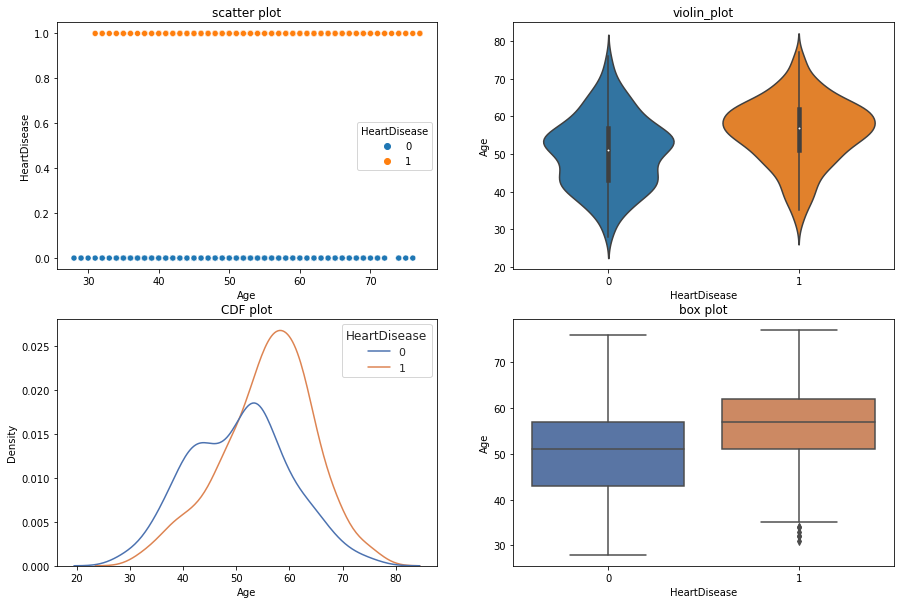



****************************************************************************************************
**************************************************RestingBP**************************************************
****************************************************************************************************



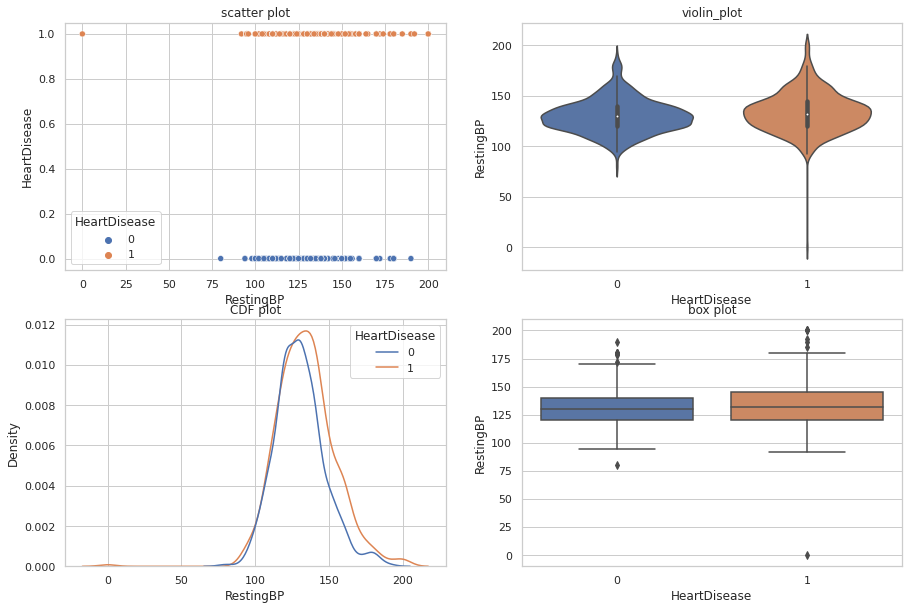



****************************************************************************************************
**************************************************Cholesterol**************************************************
****************************************************************************************************



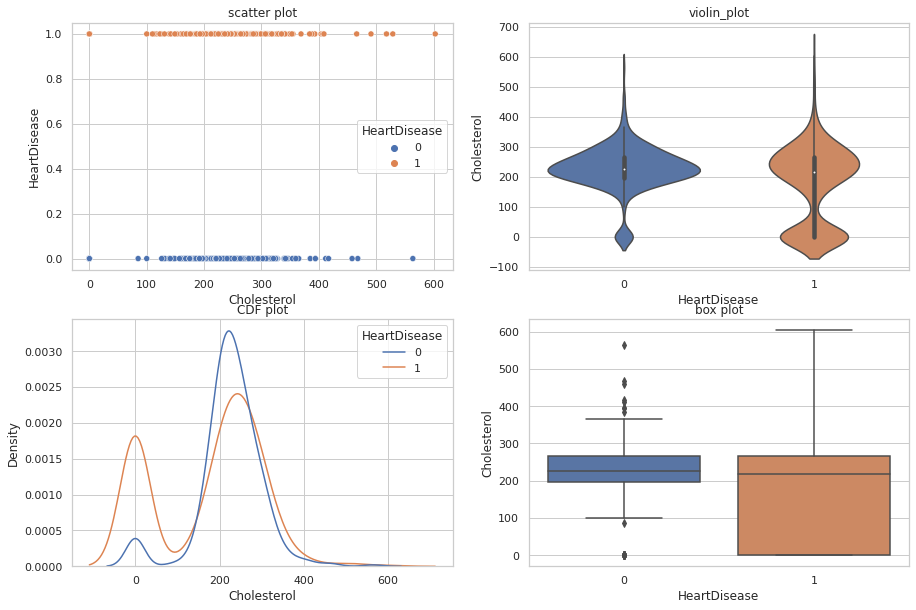



****************************************************************************************************
**************************************************MaxHR**************************************************
****************************************************************************************************



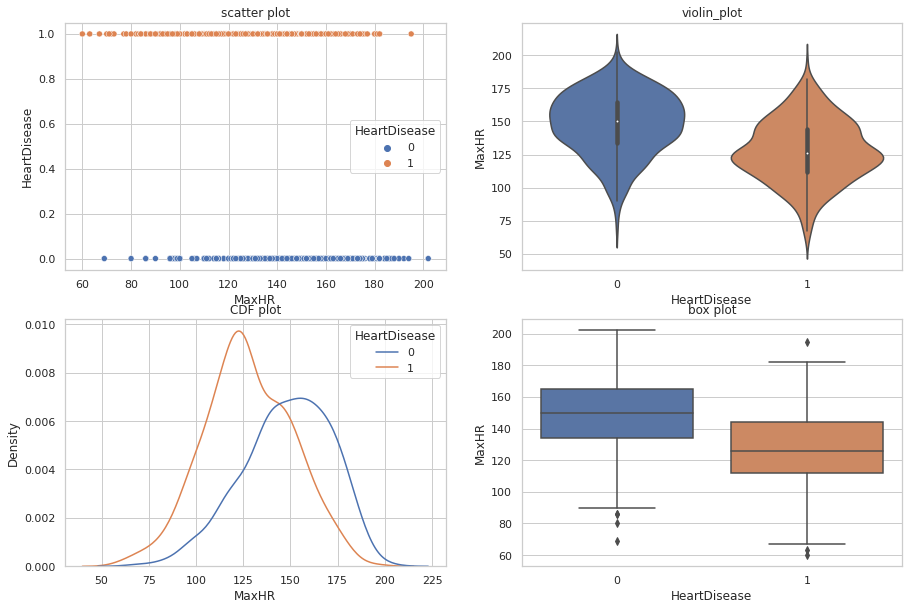



****************************************************************************************************
**************************************************Oldpeak**************************************************
****************************************************************************************************



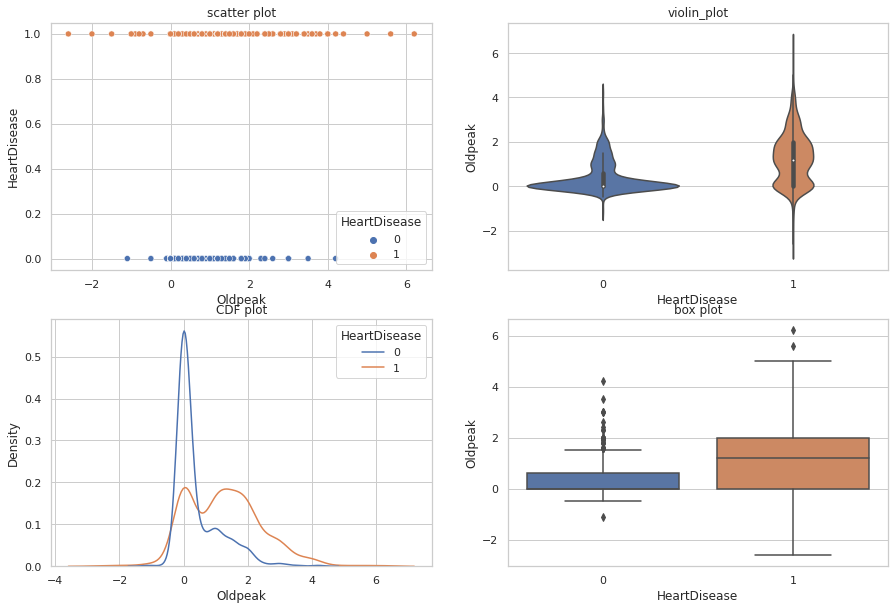

In [14]:
for value in ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']:
  plots_numerical(value)

In [15]:
def plots_categorical(datas='Sex'):
    print()
    print()
    print("*"*100)
    print("*"* 50 + 'Count Plot for ' + datas + "*"* 50)
    print("*"*100)
    print()
    sns.countplot(data=dataset, x=datas,hue = 'HeartDisease')
    plt.show()



****************************************************************************************************
**************************************************Count Plot for Sex**************************************************
****************************************************************************************************



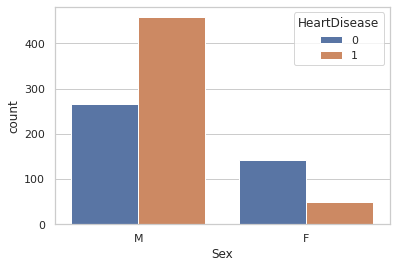



****************************************************************************************************
**************************************************Count Plot for ChestPainType**************************************************
****************************************************************************************************



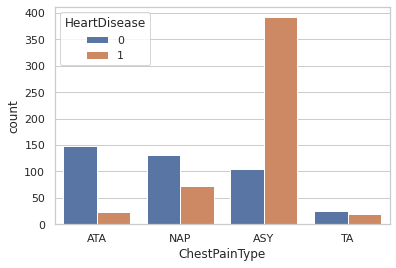



****************************************************************************************************
**************************************************Count Plot for FastingBS**************************************************
****************************************************************************************************



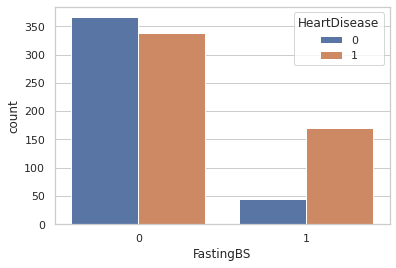



****************************************************************************************************
**************************************************Count Plot for RestingECG**************************************************
****************************************************************************************************



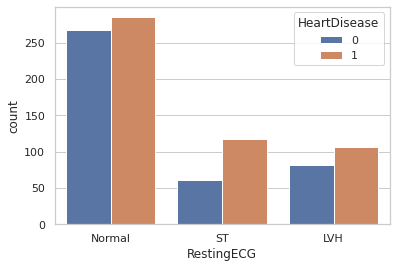



****************************************************************************************************
**************************************************Count Plot for ExerciseAngina**************************************************
****************************************************************************************************



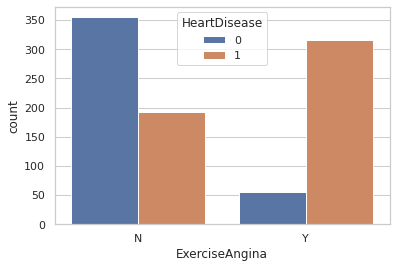



****************************************************************************************************
**************************************************Count Plot for ST_Slope**************************************************
****************************************************************************************************



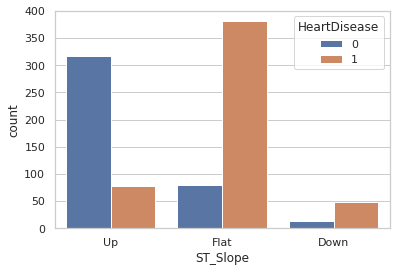

In [16]:
for value in ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']:
  plots_categorical(value)



Observations:
* All ages can heart disease , if age is less than 30 no heart disease.
* numberical data looks overlaping that means have same distribution for both the classes , hence linear models may not work correctly may be we need to use kernals (hence like mostly kernal svm may work good)
* In male heart disease is more compared to female.
* Chest pain type 'ASY' heart disaese is more.
* when fasting blood sugar is more heart disease is more.
* Astonishingly more excercise more heart disaese.
* When St slope is more , more heart disease.
* Conclusion is that univariate analysis is not that useful as excepted.lets try bi variate Analysis.

### Bi-Variate Analysis

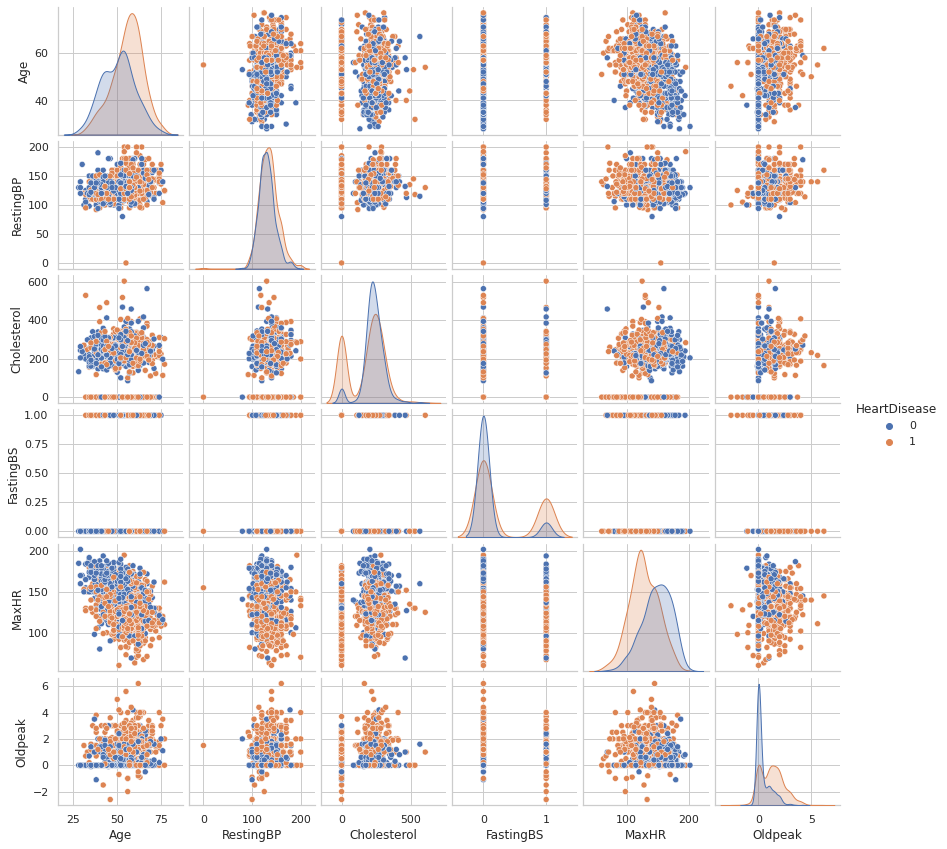

In [17]:
plt.close();
sns.set_style("whitegrid");
sns.pairplot(dataset, hue="HeartDisease", height=2);
plt.show()

Observations:
* As you can see no clear distinction , as both distributions are similar.
* Fasting Blood Sugar and maxhr and oldpeak have very little sense compared to others

### Preprocessing

#### Train Test Split with 80 and 20 

In [18]:
X_train , X_test,y_train,y_test = train_test_split(dataset.iloc[:,:-1],dataset.iloc[:,[-1]],test_size = 0.2,random_state = 42,stratify = dataset.iloc[:,[-1]])
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(734, 11)
(184, 11)
(734, 1)
(184, 1)


In [19]:
dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


#### Handling Categorical Values

* Lets use onehotencoding to increase the dimensions

In [20]:
list(X_train.iloc[:,[1,2,6,8,10]].columns)

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [21]:
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
X_train_enc_out = enc.fit_transform(X_train.iloc[:,[1,2,6,8,10]])
X_test_enc_out = enc.transform(X_test.iloc[:,[1,2,6,8,10]])
X_train_enc_columns = list(enc.get_feature_names_out(list(X_train.iloc[:,[1,2,6,8,10]].columns)))
X_test_enc_columns = list(enc.get_feature_names_out(list(X_test.iloc[:,[1,2,6,8,10]].columns)))
X_train_categorical_dataset = pd.DataFrame(data = X_train_enc_out,columns = X_train_enc_columns)
X_test_categorical_dataset = pd.DataFrame(data = X_test_enc_out,columns = X_test_enc_columns)
print(X_train_categorical_dataset.shape)
print(X_test_categorical_dataset.shape)


(734, 14)
(184, 14)


#### Standardise the numerical variables

In [22]:
list(X_train.iloc[:,[0,3,4,7,9]].columns)

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [23]:
scaler = StandardScaler()
X_train_scalar_out = scaler.fit_transform(X_train.iloc[:,[0,3,4,7,9]])
X_test_scalar_out = scaler.transform(X_test.iloc[:,[0,3,4,7,9]])
X_train_numerical_dataset = pd.DataFrame(data = X_train_scalar_out,columns = list(X_train.iloc[:,[0,3,4,7,9]].columns))
X_test_numerical_dataset = pd.DataFrame(data = X_test_scalar_out,columns = list(X_train.iloc[:,[0,3,4,7,9]].columns))
print(X_train_numerical_dataset.shape)
print(X_test_numerical_dataset.shape)

(734, 5)
(184, 5)


#### lets make final dataset for X_train and X_test

In [24]:
X_train = pd.concat([X_train_categorical_dataset,X_train.iloc[:,[5]], X_train_numerical_dataset], axis=1) 
X_test = pd.concat([X_test_categorical_dataset,X_test.iloc[:,[5]], X_test_numerical_dataset], axis=1) 
print(X_train.shape)
print(X_test.shape)

(734, 20)
(184, 20)


In [25]:
print(y_train.shape)
print(y_test.shape)

(734, 1)
(184, 1)


### Lets start Modelling

Lets Start with KNN

In [26]:
knn_clf = KNeighborsClassifier()
param_grids = {'n_neighbors' : [12,13,14,15,16,17,18]}
knn_classif = GridSearchCV(estimator = knn_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy')
knn_classif.fit(X_train,y_train)
knn_classif.best_estimator_

KNeighborsClassifier(n_neighbors=17)

Best Estimator : KNeighborsClassifier(n_neighbors=17)

In [27]:
knn_classif = KNeighborsClassifier(n_neighbors = 17)
knn_classif.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=17)

Lets see the metrics for knn

accuracy score : 0.907608695652174
f1 score : 0.9170731707317074
auc score : 0.9453610712577715
log loss : 0.4479523095124465
classification report : 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90        82
           1       0.91      0.92      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184

*********** confusion matrx ***********


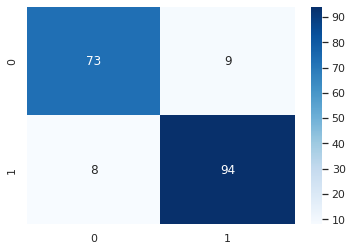

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.917073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.945361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.447952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
metrics(knn_classif,X_test,y_test,'KNN')
result_dataset

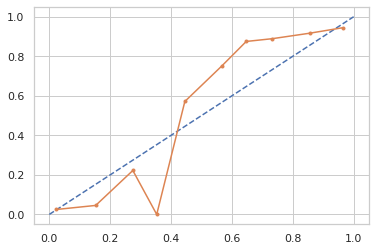

In [29]:
# predict probabilities
knn_classif_probs = knn_classif.predict_proba(X_test)[:,1]
# reliability diagram
fop, mpv = calibration_curve(y_test, knn_classif_probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets Calibrate the KNN model

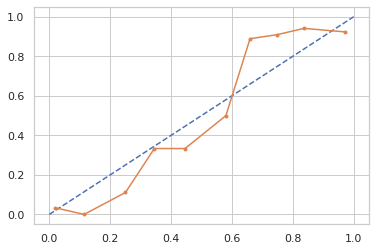

In [30]:
knn_classif = KNeighborsClassifier(n_neighbors = 17)
calibrated_knn_classif = CalibratedClassifierCV(knn_classif, method='isotonic', cv=10)
calibrated_knn_classif.fit(X_train, y_train)
# predict probabilities
calibrated_knn_classif_probs = calibrated_knn_classif.predict_proba(X_test)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, calibrated_knn_classif_probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets see the metrics of calibrated classifer

accuracy score : 0.9130434782608695
f1 score : 0.923076923076923
auc score : 0.9448828311812529
log loss : 0.2793280351280895
classification report : 
               precision    recall  f1-score   support

           0       0.92      0.88      0.90        82
           1       0.91      0.94      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184

*********** confusion matrx ***********


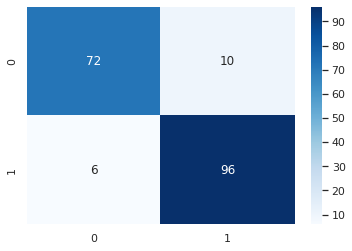

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.917073,0.923077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.945361,0.944883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.447952,0.279328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
metrics(calibrated_knn_classif,X_test,y_test,'KNN_calib')
result_dataset


### Lets Use Naive Bayes

In [32]:
naive_clf = GaussianNB()
param_grids = {'var_smoothing' : np.logspace(0,-9, num=10)}
naive_classif = GridSearchCV(estimator = naive_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy')
naive_classif.fit(X_train,y_train)
naive_classif.best_estimator_

GaussianNB(var_smoothing=0.01)

Best Estimator : GaussianNB(var_smoothing=0.01)

In [33]:
naive_classif = GaussianNB(var_smoothing=0.01)
naive_classif.fit(X_train,y_train)

GaussianNB(var_smoothing=0.01)

Lets see the metrics for NB

accuracy score : 0.875
f1 score : 0.8878048780487806
auc score : 0.9224055475848876
log loss : 0.8777252680561445
classification report : 
               precision    recall  f1-score   support

           0       0.86      0.85      0.86        82
           1       0.88      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184

*********** confusion matrx ***********


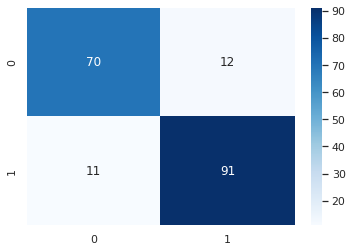

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.875000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.917073,0.923077,0.887805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.945361,0.944883,0.922406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.447952,0.279328,0.877725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
metrics(naive_classif,X_test,y_test,'NB')
result_dataset

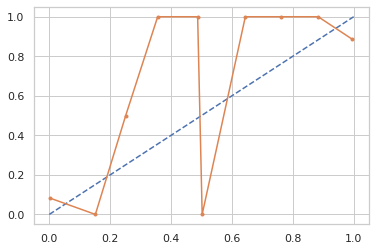

In [35]:
# predict probabilities
naive_classif_probs = naive_classif.predict_proba(X_test)[:,1]
# reliability diagram
fop, mpv = calibration_curve(y_test, naive_classif_probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets Calibrate the NB model

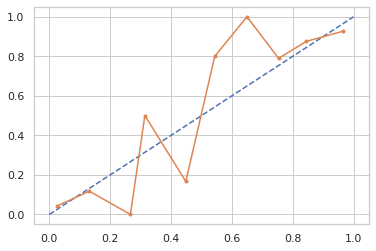

In [36]:
naive_classif = GaussianNB(var_smoothing=0.01)
calibrated_naive_classif = CalibratedClassifierCV(naive_classif, method='isotonic', cv=10)
calibrated_naive_classif.fit(X_train, y_train)
# predict probabilities
calibrated_naive_classif_probs = calibrated_naive_classif.predict_proba(X_test)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, calibrated_naive_classif_probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets see the metrics of calibrated classifer

accuracy score : 0.8967391304347826
f1 score : 0.9090909090909091
auc score : 0.9237804878048781
log loss : 0.33267025794356747
classification report : 
               precision    recall  f1-score   support

           0       0.91      0.85      0.88        82
           1       0.89      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.89       184
weighted avg       0.90      0.90      0.90       184

*********** confusion matrx ***********


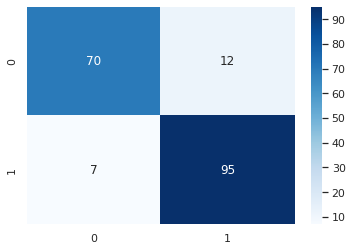

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.875000,0.896739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.917073,0.923077,0.887805,0.909091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.945361,0.944883,0.922406,0.923780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.447952,0.279328,0.877725,0.332670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
metrics(calibrated_naive_classif,X_test,y_test,'NB_calib')
result_dataset


### Lets use Logistic regression

In [38]:
logistic_clf = LogisticRegression()
param_grids = {'C': [0.0001, 0.01, 1.0, 10.0,100.0, 1000.0]}
logistic_classif = GridSearchCV(estimator = logistic_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy')
logistic_classif.fit(X_train,y_train)
logistic_classif.best_estimator_

LogisticRegression(C=10.0)

Best Estimator : LogisticRegression(C=10.0)

In [39]:
logistic_classif = LogisticRegression(C=10.0)
logistic_classif.fit(X_train,y_train)

LogisticRegression(C=10.0)

Lets see the metrics for LR

accuracy score : 0.8858695652173914
f1 score : 0.900473933649289
auc score : 0.9293400286944046
log loss : 0.33157778039272223
classification report : 
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

*********** confusion matrx ***********


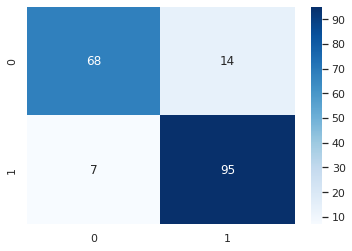

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.875000,0.896739,0.885870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.917073,0.923077,0.887805,0.909091,0.900474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.945361,0.944883,0.922406,0.923780,0.929340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.447952,0.279328,0.877725,0.332670,0.331578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
metrics(logistic_classif,X_test,y_test,'LR')
result_dataset

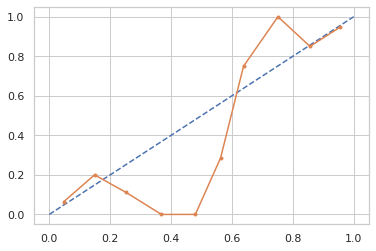

In [41]:
# predict probabilities
logistic_classif_probs = logistic_classif.predict_proba(X_test)[:,1]
# reliability diagram
fop, mpv = calibration_curve(y_test, logistic_classif_probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets Calibrate the NB model

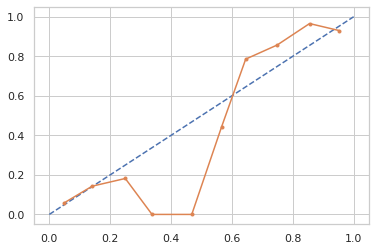

In [42]:
logistic_classif = LogisticRegression(C=10.0)
calibrated_logistic_classif = CalibratedClassifierCV(logistic_classif, method='sigmoid', cv=10)
calibrated_logistic_classif.fit(X_train, y_train)
# predict probabilities
calibrated_logistic_classif_probs = calibrated_logistic_classif.predict_proba(X_test)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, calibrated_logistic_classif_probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets see the metrics of calibrated classifer

accuracy score : 0.8804347826086957
f1 score : 0.8962264150943398
auc score : 0.9293400286944046
log loss : 0.33888456620562674
classification report : 
               precision    recall  f1-score   support

           0       0.91      0.82      0.86        82
           1       0.86      0.93      0.90       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.88       184
weighted avg       0.88      0.88      0.88       184

*********** confusion matrx ***********


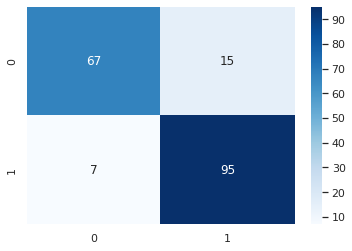

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.875000,0.896739,0.885870,0.880435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.917073,0.923077,0.887805,0.909091,0.900474,0.896226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.945361,0.944883,0.922406,0.923780,0.929340,0.929340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.447952,0.279328,0.877725,0.332670,0.331578,0.338885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
metrics(calibrated_logistic_classif,X_test,y_test,'LR_calib')
result_dataset


### Lets use Support Vector Classifier

In [44]:
svc_clf = SVC(probability = True)
param_grids = {'C': [0.0001, 0.01, 1.0, 10.0],'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],'degree':[2,3,4,5]}
svc_classif = GridSearchCV(estimator = svc_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy')
svc_classif.fit(X_train,y_train)
svc_classif.best_estimator_

SVC(degree=2, probability=True)

In [45]:
svc_classif.best_params_

{'C': 1.0, 'degree': 2, 'kernel': 'rbf'}

Best Estimator : SVC(degree=2)

In [46]:
svc_classif = SVC(degree=2, probability=True)
svc_classif.fit(X_train,y_train)

SVC(degree=2, probability=True)

Lets see the metrics for SVC

accuracy score : 0.8967391304347826
f1 score : 0.909952606635071
auc score : 0.9459588713534194
log loss : 0.2886752671193555
classification report : 
               precision    recall  f1-score   support

           0       0.92      0.84      0.88        82
           1       0.88      0.94      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.89       184
weighted avg       0.90      0.90      0.90       184

*********** confusion matrx ***********


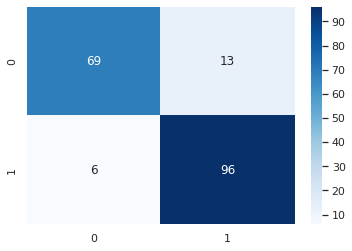

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.875000,0.896739,0.885870,0.880435,0.896739,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.917073,0.923077,0.887805,0.909091,0.900474,0.896226,0.909953,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.945361,0.944883,0.922406,0.923780,0.929340,0.929340,0.945959,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.447952,0.279328,0.877725,0.332670,0.331578,0.338885,0.288675,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
metrics(svc_classif,X_test,y_test,'SVC')
result_dataset

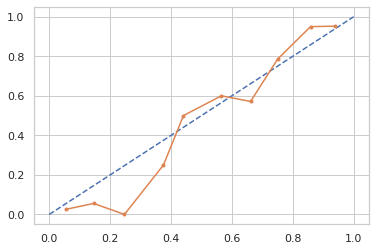

In [48]:
# predict probabilities
svc_classif_probs = svc_classif.predict_proba(X_test)[:,1]
# reliability diagram
fop, mpv = calibration_curve(y_test, svc_classif_probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets Calibrate the SVC model

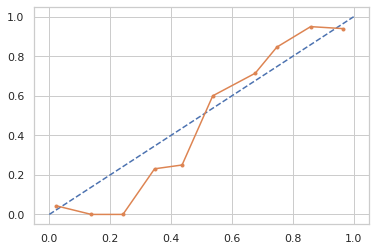

In [49]:
svc_classif = SVC(degree=2, probability=True)
calibrated_svc_classif = CalibratedClassifierCV(svc_classif, method='isotonic', cv=10)
calibrated_svc_classif.fit(X_train, y_train)
# predict probabilities
calibrated_svc_classif_probs = calibrated_svc_classif.predict_proba(X_test)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, calibrated_svc_classif_probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets see the metrics of calibrated classifer

accuracy score : 0.9021739130434783
f1 score : 0.9142857142857143
auc score : 0.9448828311812529
log loss : 0.30323104347637136
classification report : 
               precision    recall  f1-score   support

           0       0.92      0.85      0.89        82
           1       0.89      0.94      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

*********** confusion matrx ***********


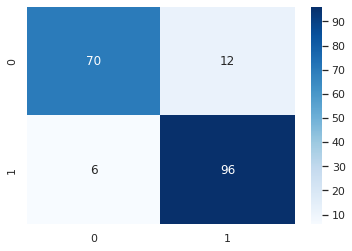

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.875000,0.896739,0.885870,0.880435,0.896739,0.902174,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.917073,0.923077,0.887805,0.909091,0.900474,0.896226,0.909953,0.914286,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.945361,0.944883,0.922406,0.923780,0.929340,0.929340,0.945959,0.944883,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.447952,0.279328,0.877725,0.332670,0.331578,0.338885,0.288675,0.303231,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
metrics(calibrated_svc_classif,X_test,y_test,'SVC_calib')
result_dataset


### Lets use Decision Trees

In [51]:
Dt_clf = DecisionTreeClassifier(max_features = 'auto',random_state = 42)
param_grids = {'criterion': ['gini','entropy'],'max_depth' : [15,16,17,18,19,20,21,22,23,24]}
Dt_classif = GridSearchCV(estimator = Dt_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy')
Dt_classif.fit(X_train,y_train)
Dt_classif.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=17, max_features='auto',
                       random_state=42)

In [52]:
Dt_classif = DecisionTreeClassifier(criterion='entropy', max_depth=17, max_features='auto',random_state=42)
Dt_classif.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=17, max_features='auto',
                       random_state=42)

Lets see the metrics for DT

accuracy score : 0.8315217391304348
f1 score : 0.8502415458937198
auc score : 0.827714012434242
log loss : 5.819106855426872
classification report : 
               precision    recall  f1-score   support

           0       0.82      0.79      0.81        82
           1       0.84      0.86      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184

*********** confusion matrx ***********


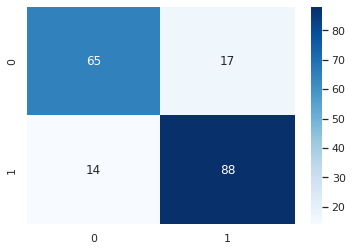

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.875000,0.896739,0.885870,0.880435,0.896739,0.902174,0.831522,0.0,0.0,0.0,0.0,0.0
f1_score,0.917073,0.923077,0.887805,0.909091,0.900474,0.896226,0.909953,0.914286,0.850242,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.945361,0.944883,0.922406,0.923780,0.929340,0.929340,0.945959,0.944883,0.827714,0.0,0.0,0.0,0.0,0.0
log_loss,0.447952,0.279328,0.877725,0.332670,0.331578,0.338885,0.288675,0.303231,5.819107,0.0,0.0,0.0,0.0,0.0


In [53]:
metrics(Dt_classif,X_test,y_test,'DT')
result_dataset

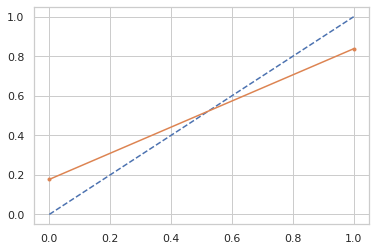

In [54]:
# predict probabilities
Dt_classif_probs = Dt_classif.predict_proba(X_test)[:,1]
# reliability diagram
fop, mpv = calibration_curve(y_test, Dt_classif_probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets Calibrate the DT model

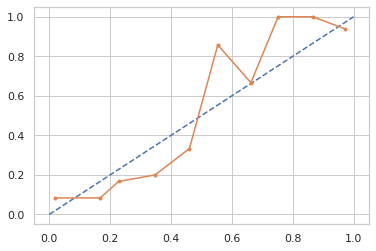

In [55]:
Dt_classif = DecisionTreeClassifier(criterion='entropy', max_depth=17, max_features='auto',random_state=42)
calibrated_Dt_classif = CalibratedClassifierCV(Dt_classif, method='isotonic', cv=10)
calibrated_Dt_classif.fit(X_train, y_train)
# predict probabilities
calibrated_Dt_classif_probs = calibrated_Dt_classif.predict_proba(X_test)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, calibrated_Dt_classif_probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets see the metrics of calibrated classifer

accuracy score : 0.9021739130434783
f1 score : 0.9126213592233009
auc score : 0.9406982305117169
log loss : 0.3898935429628772
classification report : 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        82
           1       0.90      0.92      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

*********** confusion matrx ***********


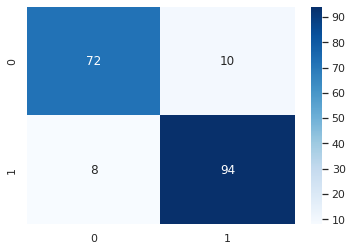

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.875000,0.896739,0.885870,0.880435,0.896739,0.902174,0.831522,0.902174,0.0,0.0,0.0,0.0
f1_score,0.917073,0.923077,0.887805,0.909091,0.900474,0.896226,0.909953,0.914286,0.850242,0.912621,0.0,0.0,0.0,0.0
roc_auc_score,0.945361,0.944883,0.922406,0.923780,0.929340,0.929340,0.945959,0.944883,0.827714,0.940698,0.0,0.0,0.0,0.0
log_loss,0.447952,0.279328,0.877725,0.332670,0.331578,0.338885,0.288675,0.303231,5.819107,0.389894,0.0,0.0,0.0,0.0


In [56]:
metrics(calibrated_Dt_classif,X_test,y_test,'DT_calib')
result_dataset


### Lets use Random Forest

In [57]:
rf_clf = RandomForestClassifier()
param_grids = {'n_estimators' : [60,65,70,75,80,85,90,95],'criterion' : ['gini', 'entropy'],'max_depth' : [15,17,19,20,22,24,25]}
rf_clf = GridSearchCV(estimator = rf_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy')
rf_clf.fit(X_train,y_train)
rf_clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=80)

In [58]:
rf_clf = RandomForestClassifier(max_depth=19, n_estimators=75)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=19, n_estimators=75)

Lets see the metrics for DT

accuracy score : 0.9021739130434783
f1 score : 0.9134615384615385
auc score : 0.9309540889526542
log loss : 0.33472580611031477
classification report : 
               precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

*********** confusion matrx ***********


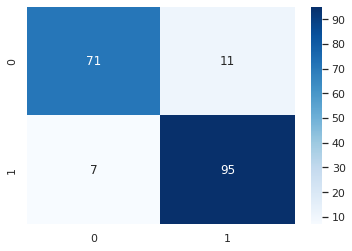

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.875000,0.896739,0.885870,0.880435,0.896739,0.902174,0.831522,0.902174,0.902174,0.0,0.0,0.0
f1_score,0.917073,0.923077,0.887805,0.909091,0.900474,0.896226,0.909953,0.914286,0.850242,0.912621,0.913462,0.0,0.0,0.0
roc_auc_score,0.945361,0.944883,0.922406,0.923780,0.929340,0.929340,0.945959,0.944883,0.827714,0.940698,0.930954,0.0,0.0,0.0
log_loss,0.447952,0.279328,0.877725,0.332670,0.331578,0.338885,0.288675,0.303231,5.819107,0.389894,0.334726,0.0,0.0,0.0


In [59]:
metrics(rf_clf,X_test,y_test,'RF')
result_dataset

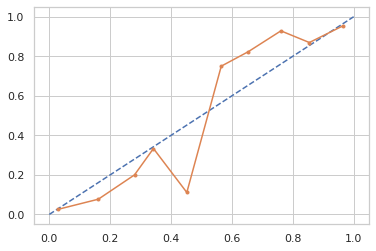

In [60]:
# predict probabilities
rf_clf_probs = rf_clf.predict_proba(X_test)[:,1]
# reliability diagram
fop, mpv = calibration_curve(y_test, rf_clf_probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets Calibrate the DT model

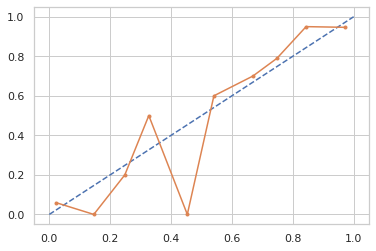

In [61]:
rf_clf = RandomForestClassifier(max_depth=19, n_estimators=75)
calibrated_rf_clf = CalibratedClassifierCV(rf_clf, method='isotonic', cv=10)
calibrated_rf_clf.fit(X_train, y_train)
# predict probabilities
calibrated_rf_clf_probs = calibrated_rf_clf.predict_proba(X_test)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, calibrated_rf_clf_probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets see the metrics of calibrated classifer

accuracy score : 0.9021739130434783
f1 score : 0.9150943396226415
auc score : 0.9382472501195601
log loss : 0.31445551469533223
classification report : 
               precision    recall  f1-score   support

           0       0.93      0.84      0.88        82
           1       0.88      0.95      0.92       102

    accuracy                           0.90       184
   macro avg       0.91      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

*********** confusion matrx ***********


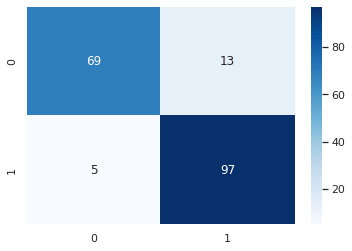

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.875000,0.896739,0.885870,0.880435,0.896739,0.902174,0.831522,0.902174,0.902174,0.902174,0.0,0.0
f1_score,0.917073,0.923077,0.887805,0.909091,0.900474,0.896226,0.909953,0.914286,0.850242,0.912621,0.913462,0.915094,0.0,0.0
roc_auc_score,0.945361,0.944883,0.922406,0.923780,0.929340,0.929340,0.945959,0.944883,0.827714,0.940698,0.930954,0.938247,0.0,0.0
log_loss,0.447952,0.279328,0.877725,0.332670,0.331578,0.338885,0.288675,0.303231,5.819107,0.389894,0.334726,0.314456,0.0,0.0


In [62]:
metrics(calibrated_rf_clf,X_test,y_test,'RF_calib')
result_dataset


### Lets use Boosting

In [63]:
gbdt_clf = GradientBoostingClassifier(random_state = 42)
param_grids = {'loss' : ['log_loss', 'deviance', 'exponential'],'learning_rate' : [0.1,0.3,0.6,0.9],'n_estimators':[80,90,100,110],'criterion':['friedman_mse','squared_error','mse']}
gbdt_clf = GridSearchCV(estimator = gbdt_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy')
gbdt_clf.fit(X_train,y_train)
gbdt_clf.best_estimator_

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           random_state=42)

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           random_state=42)

In [64]:
gbdt_clf = GradientBoostingClassifier(learning_rate=0.3, loss='exponential', random_state=42)
gbdt_clf.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           random_state=42)

Lets see the metrics for GBDT

accuracy score : 0.8641304347826086
f1 score : 0.8756218905472637
auc score : 0.9263510282161646
log loss : 0.49582464883724303
classification report : 
               precision    recall  f1-score   support

           0       0.84      0.87      0.85        82
           1       0.89      0.86      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184

*********** confusion matrx ***********


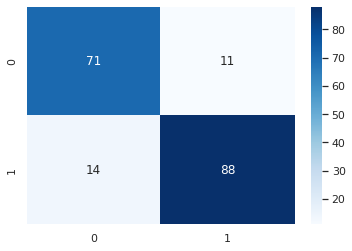

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.875000,0.896739,0.885870,0.880435,0.896739,0.902174,0.831522,0.902174,0.902174,0.902174,0.864130,0.0
f1_score,0.917073,0.923077,0.887805,0.909091,0.900474,0.896226,0.909953,0.914286,0.850242,0.912621,0.913462,0.915094,0.875622,0.0
roc_auc_score,0.945361,0.944883,0.922406,0.923780,0.929340,0.929340,0.945959,0.944883,0.827714,0.940698,0.930954,0.938247,0.926351,0.0
log_loss,0.447952,0.279328,0.877725,0.332670,0.331578,0.338885,0.288675,0.303231,5.819107,0.389894,0.334726,0.314456,0.495825,0.0


In [65]:
metrics(gbdt_clf,X_test,y_test,'GBDT')
result_dataset

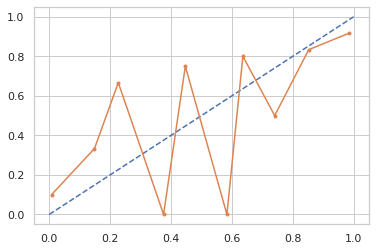

In [66]:
# predict probabilities
gbdt_clf_probs = gbdt_clf.predict_proba(X_test)[:,1]
# reliability diagram
fop, mpv = calibration_curve(y_test, gbdt_clf_probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets Calibrate the GBDT model

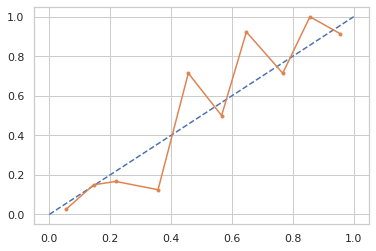

In [67]:
gbdt_clf = GradientBoostingClassifier(learning_rate=0.3, loss='exponential', random_state=42)
calibrated_gbdt_clf = CalibratedClassifierCV(gbdt_clf, method='sigmoid', cv=10)
calibrated_gbdt_clf.fit(X_train, y_train)
# predict probabilities
calibrated_gbdt_clf_probs = calibrated_gbdt_clf.predict_proba(X_test)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, calibrated_gbdt_clf_probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Lets see the metrics of calibrated classifer

accuracy score : 0.875
f1 score : 0.8878048780487806
auc score : 0.9274270683883309
log loss : 0.33815485091436026
classification report : 
               precision    recall  f1-score   support

           0       0.86      0.85      0.86        82
           1       0.88      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184

*********** confusion matrx ***********


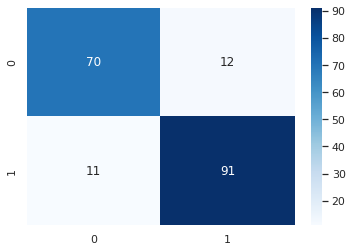

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.907609,0.913043,0.875000,0.896739,0.885870,0.880435,0.896739,0.902174,0.831522,0.902174,0.902174,0.902174,0.864130,0.875000
f1_score,0.917073,0.923077,0.887805,0.909091,0.900474,0.896226,0.909953,0.914286,0.850242,0.912621,0.913462,0.915094,0.875622,0.887805
roc_auc_score,0.945361,0.944883,0.922406,0.923780,0.929340,0.929340,0.945959,0.944883,0.827714,0.940698,0.930954,0.938247,0.926351,0.927427
log_loss,0.447952,0.279328,0.877725,0.332670,0.331578,0.338885,0.288675,0.303231,5.819107,0.389894,0.334726,0.314456,0.495825,0.338155


In [68]:
metrics(calibrated_gbdt_clf,X_test,y_test,'GBDT_calib')
result_dataset
